C:\Users\yayy_\AppData\Local\Temp\ipykernel_16976\3463426049.py:18: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv(file_path, header=None, names=['des_flux', 'detrap_en', 'def_conc'], index_col=None, squeeze = True)
C:\Users\yayy_\AppData\Local\Temp\ipykernel_16976\3463426049.py:18: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv(file_path, header=None, names=['des_flux', 'detrap_en', 'def_conc'], index_col=None, squeeze = True)
C:\Users\yayy_\AppData\Local\Temp\ipykernel_16976\3463426049.py:18: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv(file_path, header=None, names=['des_flux', 'detrap_en', 'def_conc'], index_col=None, sq

Error in file: D:\School\Nano120\TDS_15000\TDS_data_15000\TSFresh.ipynb


0
0      1.202602
1      1.511330
2      1.514125
3      1.416363
4      1.580196
...         ...
14995  1.646276
14996  1.566460
14997  1.655664
14998  1.361097
14999  1.308750

[15000 rows x 1 columns]

0
0      0.012987
1      0.007481
2      0.011929
3      0.013044
4      0.014363
...         ...
14995  0.012199
14996  0.014365
14997  0.012734
14998  0.009443
14999  0.012198

[15000 rows x 1 columns]

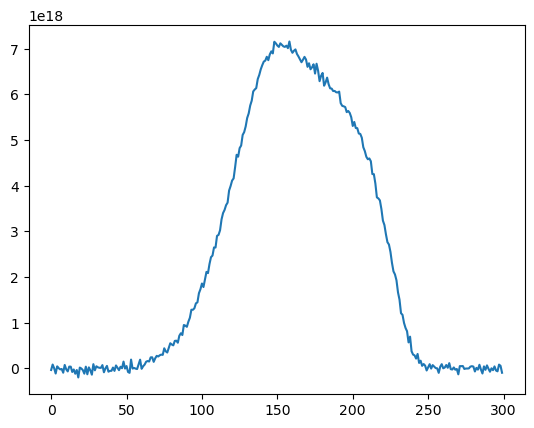

0    -2.486207e-16
id    7.524500e+03
dtype: float64

0        1.000000
id    4344.561247
dtype: float64

0    -0.881514
id    0.000000
dtype: float64

0         7.023513
id    15049.000000
dtype: float64

Feature Extraction:   0%|          | 0/40 [00:03<?, ?it/s]


TypeError: acf() got an unexpected keyword argument 'unbiased'

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Load and preprocess the data

folder_path = r'D:\School\Nano120\TDS_15000\TDS_data_15000'
    # Niki - issues with file path string, using raw string by prefixing the string with 'r'

#folder_path = r'D:\School\Nano120\r05_1k'
data = {}

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        try:
            df = pd.read_csv(file_path, header=None, names=['des_flux', 'detrap_en', 'def_conc'], index_col=None, squeeze = True)
            data[filename] = df
        except pd.errors.ParserError:
            print(f"Error in file: {file_path}")
            
# Combine all the data into a single dataframe
df = pd.concat(data.values())

#display(df)

#reshape suggestion 

des_flux=df['des_flux']
des_flux=des_flux.tolist()
num_files = len(des_flux)
num_cols = len(des_flux)
des_flux = df['des_flux'].values.reshape(-1, 300)

#display(des_flux)

#Possible optimization is to combine the code for detrap_en and def_con into a function, this avoid code duplication
def process_column(df, column_name):
    column = df[column_name]
    column = column.dropna()
    column = column.tolist()
    num_files = len(column) // 4
    column = np.reshape(column, [num_files, 4])
    column_mean = column.mean(axis=1)
    column = pd.DataFrame(column)
    column_mean = pd.DataFrame(column_mean)
    display(column_mean)
    return column, column_mean

detrap_en, detrap_en_mean = process_column(df, 'detrap_en')
def_conc, def_conc_mean = process_column(df, 'def_conc')


#Guassian Noise
# Option 2. pre-allocate the 'noise_array' and 'sigma_list' arrays instead of appending to them in each loop iterations.

noise_array = np.zeros_like(des_flux, dtype=np.ndarray)
sigma_list = np.zeros(len(des_flux), dtype=np.ndarray)
for n in range(len(des_flux)):
    sigma_rand = np.random.uniform(1E14, 1E17)
    spect_wnoise = np.random.normal(des_flux[n], sigma_rand, size=len(des_flux[n]))
    noise_array[n] = spect_wnoise
    sigma_list[n] = str(sigma_rand)
plt.plot(noise_array[4])
plt.show()

#Preparation for feature extraction

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
des_flux_norm = scaler.fit_transform(des_flux.reshape(-1, 1))
des_flux_norm=pd.DataFrame(des_flux_norm)
des_flux_id = np.arange(0,des_flux_norm.shape[0])
des_flux_id = des_flux_id // 300
des_flux_norm["id"] = des_flux_id

#Checking for proper shape
#and statistics

display(des_flux_norm.mean(), des_flux_norm.std(), des_flux_norm.min(), des_flux_norm.max())

#Feature Extraction and Selection
from statsmodels.tsa.stattools import acf
from tsfresh import extract_features
from tsfresh import select_features 
from tsfresh.utilities.dataframe_functions import impute

features = extract_features(des_flux_norm, column_id="id", column_sort="id")

# perform feature selection
features_filtered = select_features(features, detrap_en_mean)

# impute missing values
features_filtered = impute(features_filtered)

# calculate autocorrelation
acf_values = [] 
for i in range(len(des_flux_norm)):
    acf_values = acf(des_flux_norm[i], nlags = 10, fit = True)
    acf_values.append(acf_values)